# Using LittleVGG for Emotion Detection

### Training Emotion Detector

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 6
img_rows, img_cols = 48, 48
batch_size = 16

train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


## Our Keras Imports

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense

## Keras LittleVGG Model

In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                       

## Training our model

In [5]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("/Users/sarvagyasamridhsingh/Documents/Programming/conda3/Objectdetection/udemyCV/DeepLearningCV/Trained Models/emotion_little_vgg_3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 28273
nb_validation_samples = 3534
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20


/var/folders/9b/47hy5j7j39379t2ycr9nv4jc0000gn/T/ipykernel_28474/263021586.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1767/1767 [==============================] - ETA: 0s - loss: 1.9226 - accuracy: 0.2123
Epoch 1: val_loss improved from inf to 1.75973, saving model to /Users/sarvagyasamridhsingh/Documents/Programming/conda3/Objectdetection/udemyCV/DeepLearningCV/Trained Models/emotion_little_vgg_3.h5
1767/1767 [==============================] - 167s 93ms/step - loss: 1.9226 - accuracy: 0.2123 - val_loss: 1.7597 - val_accuracy: 0.2281 - lr: 0.0010
Epoch 2/20
   1/1767 [..............................] - ETA: 3:11 - loss: 1.6020 - accuracy: 0.2500

/Users/sarvagyasamridhsingh/anaconda3/envs/av/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1767/1767 [==============================] - ETA: 0s - loss: 1.7472 - accuracy: 0.2487
Epoch 2: val_loss improved from 1.75973 to 1.73225, saving model to /Users/sarvagyasamridhsingh/Documents/Programming/conda3/Objectdetection/udemyCV/DeepLearningCV/Trained Models/emotion_little_vgg_3.h5
1767/1767 [==============================] - 168s 95ms/step - loss: 1.7472 - accuracy: 0.2487 - val_loss: 1.7322 - val_accuracy: 0.2614 - lr: 0.0010
Epoch 3/20
1767/1767 [==============================] - ETA: 0s - loss: 1.7381 - accuracy: 0.2545
Epoch 3: val_loss did not improve from 1.73225
1767/1767 [==============================] - 168s 95ms/step - loss: 1.7381 - accuracy: 0.2545 - val_loss: 1.8125 - val_accuracy: 0.2241 - lr: 0.0010
Epoch 4/20
1767/1767 [==============================] - ETA: 0s - loss: 1.7136 - accuracy: 0.2704
Epoch 4: val_loss improved from 1.73225 to 1.71017, saving model to /Users/sarvagyasamridhsingh/Documents/Programming/conda3/Objectdetection/udemyCV/DeepLearningCV/Train

Found 3534 images belonging to 6 classes.


/var/folders/9b/47hy5j7j39379t2ycr9nv4jc0000gn/T/ipykernel_28474/3546348033.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


Confusion Matrix
[[138  18  52  79 165  39]
 [ 82   8  66 119 126 127]
 [ 15   9 754  38  44  19]
 [ 74   9 167 160 130  86]
 [ 55   8  54 154 302  21]
 [ 16   6  44  29  11 310]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.36      0.28      0.32       491
        Fear       0.14      0.02      0.03       528
       Happy       0.66      0.86      0.75       879
     Neutral       0.28      0.26      0.27       626
         Sad       0.39      0.51      0.44       594
    Surprise       0.51      0.75      0.61       416

    accuracy                           0.47      3534
   macro avg       0.39      0.44      0.40      3534
weighted avg       0.41      0.47      0.43      3534



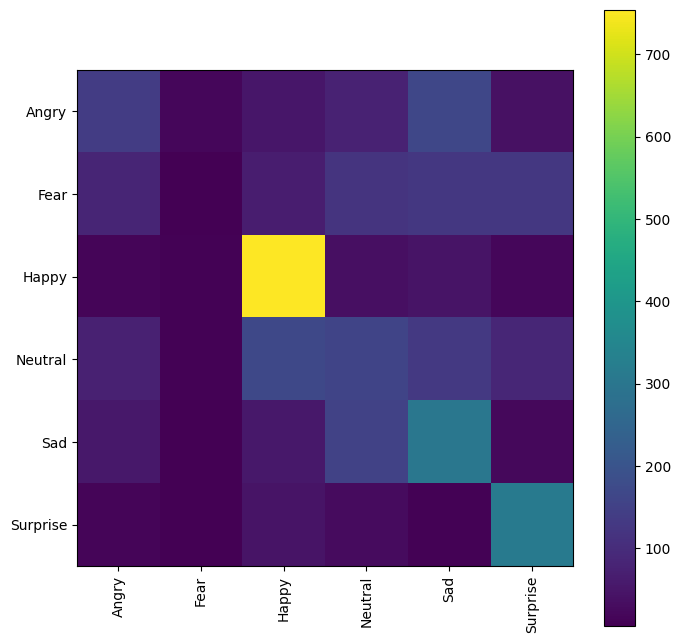

In [6]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28273
nb_validation_samples = 3534

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Loading our saved model

In [9]:
from keras.models import load_model

classifier = load_model('/Users/sarvagyasamridhsingh/Documents/Programming/conda3/Objectdetection/udemyCV/DeepLearningCV/Trained Models/emotion_little_vgg_3.h5')

### Get our class labels

In [10]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 3534 images belonging to 6 classes.
{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}


### Let's test on some of validation images

In [11]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = './fer2013/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

AttributeError: 'Sequential' object has no attribute 'predict_classes'

### Test on a single image

In [7]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("rajeev.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

### Let's try this on our webcam


In [12]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/9b/47hy5j7j39379t2ycr9nv4jc0000gn/T/ipykernel_28474/1099583068.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


KeyboardInterrupt: 

In [ ]:
cap.release()
cv2.destroyAllWindows()      